In [1]:
!pip3 install graphtsetlinmachine

In [2]:
import argparse
import numpy as np
import pandas as pd
from time import time
from GraphTsetlinMachine.graphs import Graphs
from GraphTsetlinMachine.tm import MultiClassGraphTsetlinMachine

clauses=5000

def default_args(**kwargs):
    parser = argparse.ArgumentParser()
    parser.add_argument("--epochs", default=1000, type=int)
    parser.add_argument("--number-of-clauses", default=clauses, type=int)
    #parser.add_argument("--number-of-state-bits", default=8, type=int)
    parser.add_argument("--T", default=clauses/1.6, type=int)
    parser.add_argument("--s", default=1.06, type=float)
    parser.add_argument("--depth", default=1, type=int)
    parser.add_argument("--hypervector-size", default=512, type=int)
    parser.add_argument("--hypervector-bits", default=32, type=int)
    parser.add_argument("--message-size", default=512, type=int)
    parser.add_argument("--message-bits", default=32, type=int)
    parser.add_argument('--double-hashing', dest='double_hashing', default=True, action='store_true')
    parser.add_argument("--number-of-examples", default=100000, type=int)
    #parser.add_argument("--max-included-literals", default=128, type=int)

    args, unknown = parser.parse_known_args()
    for key, value in kwargs.items():
        if key in args.__dict__:
            setattr(args, key, value)
    return args

args = default_args()

In [ ]:
dataset = pd.read_csv('generated_10x10.csv')
dataset = dataset.head(args.number_of_examples)

board_size = 10

split_ratio = 0.9
split_index = int(len(dataset) * split_ratio)
train_dataset = dataset.iloc[:split_index]
test_dataset = dataset.iloc[split_index:]

X_train_board = train_dataset['board'].values
Y_train = train_dataset['winner'].values.astype(np.uint32)
X_test_board = test_dataset['board'].values
Y_test = test_dataset['winner'].values.astype(np.uint32)

cell_value_mapping = {
    0: 'Empty',
    1: 'Red',
    2: 'Blue'
}

edge_type_mapping = {
    0: 'Plain',
    1: 'Red',
    2: 'Blue',
    3: 'Corner'
}

def parse_board(board_string):
    game_state = {}
    board_string = board_string.replace(' ', '')
    for idx, symbol in enumerate(board_string):
        i = idx // board_size
        j = idx % board_size
        node_id = i * board_size + j
        if symbol == 'X':
            cell_value = 1
        elif symbol == 'O':
            cell_value = 2
        else:
            cell_value = 0
        game_state[node_id] = cell_value
    return game_state

train_games = [parse_board(board_string) for board_string in X_train_board]
test_games = [parse_board(board_string) for board_string in X_test_board]

train_graph_length = len(train_games)
test_graph_length = len(test_games)

edges = {}
for i in range(board_size):
    for j in range(board_size):
        node = (i, j)
        edges[node] = []

def addedge(node1, node2):
    if node2 not in edges[node1]:
        edges[node1].append(node2)

for i in range(board_size):
    for j in range(board_size):
        node = (i, j)

        if i < board_size - 1:
            addedge(node, (i + 1, j))
            addedge((i + 1, j), node)

            if j > 0:
                addedge(node, (i + 1, j - 1))
                addedge((i + 1, j - 1), node)

        if j < board_size - 1:
            addedge(node, (i, j + 1))
            addedge((i, j + 1), node)

        if i > 0:
            addedge(node, (i - 1, j))
            addedge((i - 1, j), node)

        if j > 0:
            addedge(node, (i, j - 1))
            addedge((i, j - 1), node)

node_indices = {}
index = 0
for i in range(board_size):
    for j in range(board_size):
        node = (i, j)
        node_indices[node] = index
        index += 1

ModuleNotFoundError: No module named 'src'

In [7]:
symbols = set()

for i in range(board_size):
    for j in range(board_size):
        symbols.update([
            'Empty',
            'Red',
            'Blue',
            f'connected_{i}_{j}',
            f'node_{i}_{j}',
            f'c{i}',
            f'r{j}'
        ])

symbols = list(symbols)

In [9]:
print(len(symbols))

223


In [154]:
print('Creating training data')

symbols = []

for i in range(board_size):
    for j in range(board_size):
        symbols.extend([
            f'Empty_{i}_{j}',
            f'Red_{i}_{j}',
            f'Blue_{i}_{j}',
            f'connected_{i}_{j}',
            f'c{i+1}_{i}_{j}',
            f'r{j+1}_{i}_{j}'
        ])


# Adjust hypervector size and bits
args.hypervector_size = len(symbols)  # Each symbol gets a unique bit
args.hypervector_bits = 1

graphs_train = Graphs(
    train_graph_length,
    symbols=symbols,
    hypervector_size=args.hypervector_size,
    hypervector_bits=args.hypervector_bits
)

for graph_id in range(train_graph_length):
    graphs_train.set_number_of_graph_nodes(graph_id, board_size ** 2)

graphs_train.prepare_node_configuration()

for graph_id in range(train_graph_length):
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            number_of_outgoing_edges = len(edges[node])
            graphs_train.add_graph_node(graph_id, node_id, number_of_outgoing_edges)

graphs_train.prepare_edge_configuration()

for graph_id in range(train_graph_length):
    game = train_games[graph_id]
    if graph_id % 10000 == 0:
        print('Adding edges for graph id:', graph_id)
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            cell_value = game.get(node_id, 0)
            #if graph_id == 0:
                #print(f"Cell_value: {cell_value}")
            edge_type = edge_type_mapping[0]

            for neighbor in edges[node]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    edge_type_value = edge_type_mapping.get(cell_value)
                    graphs_train.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type_value)
                else:
                    graphs_train.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type)
                
for graph_id in range(train_graph_length):
    game = train_games[graph_id]
    if graph_id % 10000 == 0:
        print('Adding properties for graph id:', graph_id)
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            cell_value = game.get(node_id, 0)
            cell_property = cell_value_mapping.get(cell_value)
            graphs_train.add_graph_node_property(graph_id, node_id, f"{cell_property}_{i}_{j}")

            num_neigh = 0
            for neighbor in edges[(i, j)]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    num_neigh += 1
            if num_neigh > 1:
                graphs_train.add_graph_node_property(graph_id, node_id, f"connected_{i}_{j}")

            graphs_train.add_graph_node_property(graph_id, node_id, f"c{i+1}_{i}_{j}")
            graphs_train.add_graph_node_property(graph_id, node_id, f"r{j+1}_{i}_{j}")



graphs_train.encode()

Creating training data
Adding edges for graph id: 0
Adding edges for graph id: 10000
Adding edges for graph id: 20000
Adding edges for graph id: 30000
Adding edges for graph id: 40000
Adding edges for graph id: 50000
Adding edges for graph id: 60000
Adding edges for graph id: 70000
Adding edges for graph id: 80000
Adding properties for graph id: 0
Adding properties for graph id: 10000
Adding properties for graph id: 20000
Adding properties for graph id: 30000
Adding properties for graph id: 40000
Adding properties for graph id: 50000
Adding properties for graph id: 60000
Adding properties for graph id: 70000
Adding properties for graph id: 80000


In [155]:
# Test graph
print("Creating test data")
graphs_test = Graphs(test_graph_length, init_with=graphs_train)

for graph_id in range(test_graph_length):
    graphs_test.set_number_of_graph_nodes(graph_id, board_size ** 2)

graphs_test.prepare_node_configuration()

for graph_id in range(test_graph_length):
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            number_of_outgoing_edges = len(edges[node])
            graphs_test.add_graph_node(graph_id, node_id, number_of_outgoing_edges)

graphs_test.prepare_edge_configuration()

for graph_id in range(test_graph_length):
    game = test_games[graph_id]
    if graph_id % 1000 == 0:
        print('Adding edges for graph id:', graph_id)
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            node = (i, j)
            cell_value = game.get(node_id, 0)
            edge_type = edge_type_mapping[0]

            for neighbor in edges[node]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    edge_type_value = edge_type_mapping.get(cell_value)
                    graphs_test.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type_value)
                else:
                    graphs_test.add_graph_node_edge(graph_id, node_id, neighbor_id, edge_type)

for graph_id in range(test_graph_length):
    game = test_games[graph_id]
    if graph_id % 10000 == 0:
        print('Adding properties for graph id:', graph_id)
    for i in range(board_size):
        for j in range(board_size):
            node_id = i * board_size + j
            cell_value = game.get(node_id, 0)
            cell_property = cell_value_mapping.get(cell_value)
            graphs_test.add_graph_node_property(graph_id, node_id, f"{cell_property}_{i}_{j}")

            num_neigh = 0
            for neighbor in edges[(i, j)]:
                neighbor_i, neighbor_j = neighbor
                neighbor_id = neighbor_i * board_size + neighbor_j
                cell_neighbor = game.get(neighbor_id, 0)
                if cell_value == cell_neighbor and cell_value != 0:
                    num_neigh += 1
            if num_neigh > 1:
                graphs_test.add_graph_node_property(graph_id, node_id, f"connected_{i}_{j}")

            graphs_test.add_graph_node_property(graph_id, node_id, f"c{i+1}_{i}_{j}")
            graphs_test.add_graph_node_property(graph_id, node_id, f"r{j+1}_{i}_{j}")



graphs_test.encode()


Creating test data
Adding edges for graph id: 0
Adding edges for graph id: 1000
Adding edges for graph id: 2000
Adding edges for graph id: 3000
Adding edges for graph id: 4000
Adding edges for graph id: 5000
Adding edges for graph id: 6000
Adding edges for graph id: 7000
Adding edges for graph id: 8000
Adding edges for graph id: 9000
Adding properties for graph id: 0


In [156]:
train_acc = []
test_acc = []
epoch_list = []
epoch = 0


tm = MultiClassGraphTsetlinMachine(
    args.number_of_clauses,
    args.T,
    args.s,
    #number_of_state_bits = args.number_of_state_bits,
    depth=args.depth,
    message_size=args.message_size,
    message_bits=args.message_bits,
    #max_included_literals=args.max_included_literals,
    grid=(16*13,1,1),
    block=(128,1,1)
)

for i in range(args.epochs):
    epoch+=1
    start_training = time()
    tm.fit(graphs_train, Y_train, epochs=1, incremental=True)
    stop_training = time()

    start_testing = time()
    result_test = 100*(tm.predict(graphs_test) == Y_test).mean()
    stop_testing = time()

    result_train = 100*(tm.predict(graphs_train) == Y_train).mean()

    train_acc.append(result_train)
    test_acc.append(result_test)
    epoch_list.append(epoch)

    print(f"Epoch: {i}, Train acc: {result_train:.2f}, Test acc: {result_test:.2f}, Epoch time: {stop_testing-start_training:.2f}")

weights = tm.get_state()[1].reshape(2, -1)
# for i in range(tm.number_of_clauses):
#         print("Clause #%d W:(%d %d)" % (i, weights[0,i], weights[1,i]), end=' ')
#         l = []
#         for k in range(args.hypervector_size * 2):
#             if tm.ta_action(0, i, k):
#                 if k < args.hypervector_size:
#                     l.append("x%d" % (k))
#                 else:
#                     l.append("NOT x%d" % (k - args.hypervector_size))


#         print(" AND ".join(l))

#print(graphs_test.hypervectors)
#print(tm.hypervectors)
print(graphs_test.edge_type_id)


Initialization of sparse structure.
Epoch: 0, Train acc: 96.21, Test acc: 96.44, Epoch time: 40.87
Epoch: 1, Train acc: 98.02, Test acc: 98.11, Epoch time: 32.05
Epoch: 2, Train acc: 98.28, Test acc: 98.36, Epoch time: 30.09
Epoch: 3, Train acc: 98.97, Test acc: 98.97, Epoch time: 28.94
Epoch: 4, Train acc: 98.80, Test acc: 98.89, Epoch time: 28.14
Epoch: 5, Train acc: 97.55, Test acc: 97.59, Epoch time: 27.66
Epoch: 6, Train acc: 98.99, Test acc: 98.94, Epoch time: 27.29
Epoch: 7, Train acc: 98.94, Test acc: 98.92, Epoch time: 26.96
Epoch: 8, Train acc: 98.75, Test acc: 98.73, Epoch time: 26.76
Epoch: 9, Train acc: 99.40, Test acc: 99.43, Epoch time: 26.55
Epoch: 10, Train acc: 99.04, Test acc: 99.01, Epoch time: 26.40
Epoch: 11, Train acc: 99.39, Test acc: 99.36, Epoch time: 26.22
Epoch: 12, Train acc: 98.82, Test acc: 98.82, Epoch time: 26.10
Epoch: 13, Train acc: 99.12, Test acc: 99.10, Epoch time: 26.01
Epoch: 14, Train acc: 98.46, Test acc: 98.52, Epoch time: 25.91
Epoch: 15, Tra

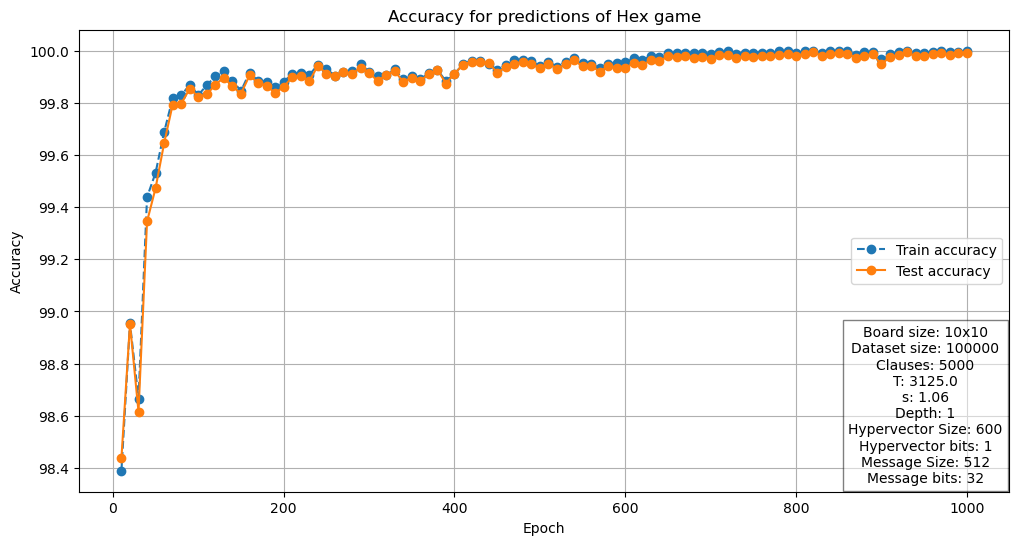

In [163]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=20):
    return [np.mean(data[i:i+window_size]) for i in range(0, len(data), window_size)]

train_acc_smooth = moving_average(train_acc, window_size=10)
test_acc_smooth = moving_average(test_acc, window_size=10)

epoch_list_smooth = epoch_list[9::10]

plt.figure(figsize=(12, 6))

plt.plot(epoch_list_smooth, train_acc_smooth, label="Train accuracy", marker='o', linestyle='--')
plt.plot(epoch_list_smooth, test_acc_smooth, label="Test accuracy", marker='o', linestyle='-')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy for predictions of Hex game')

plt.legend(loc=5)

parameters_text = f"Board size: {board_size}x{board_size}\nDataset size: {len(dataset)}\nClauses: {args.number_of_clauses}\nT: {args.T}\ns: {args.s}\nDepth: {args.depth}\nHypervector Size: {args.hypervector_size}\nHypervector bits: {args.hypervector_bits}\nMessage Size: {args.message_size}\nMessage bits: {args.message_bits}"
plt.text(0.91, 0.02, parameters_text, transform=plt.gca().transAxes, fontsize=10,
         ha='center', bbox=dict(facecolor='white', alpha=0.5))

plt.grid(True)
plt.savefig('hex_game_10x10-gpt.png')
plt.show()

In [160]:
####
## THIS PART AND THE FOLLOWING PARTS OF THE CODE HAS BEEN CREATED WITH CHATGPT,
TO TRANSFORM AND VISUALIZE CLAUSES FROM HYPERVECTOR TO THE BOARD
####

import matplotlib.pyplot as plt
import numpy as np

def visualize_clause(clause_literals):
    board = np.zeros((board_size, board_size), dtype=int)
    for literal in clause_literals:
        # Parse the literal to extract symbol and node position
        if 'NOT ' in literal:
            continue  # Skip negative literals for visualization
        symbol_with_position = literal
        symbol_parts = symbol_with_position.split('_')
        if len(symbol_parts) >= 3:
            symbol = symbol_parts[0]
            i = int(symbol_parts[1])
            j = int(symbol_parts[2])
            if symbol == 'Red':
                board[i, j] = 1
            elif symbol == 'Blue':
                board[i, j] = 2
            elif symbol == 'Empty':
                board[i, j] = 0
            # Handle other symbols if needed (e.g., 'connected', 'r', 'c')
    plt.figure(figsize=(6, 6))
    plt.imshow(board, cmap='coolwarm', interpolation='none', extent=[0, board_size, board_size, 0])
    plt.title('Clause Visualization')
    plt.colorbar(ticks=[0, 1, 2], label='Cell Value')
    plt.show()

In [161]:
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt

def parse_clause(clause_str):
    literals = clause_str.split(' AND ')
    clause_info = []
    for literal in literals:
        if 'NOT ' in literal:
            is_not = True
            literal = literal.replace('NOT ', '')
        else:
            is_not = False

        parts = literal.split('_')
        if len(parts) >= 3:
            symbol = parts[0]
            i = int(parts[1])
            j = int(parts[2])
            clause_info.append({
                'symbol': symbol,
                'i': i,
                'j': j,
                'is_not': is_not
            })
    return clause_info

def visualize_clause_on_board(size, clause_info):
    import matplotlib.pyplot as plt
    import networkx as nx
    from math import sqrt

    G = nx.Graph()
    node_features = {}

    # Build nodes for the hex board
    for q in range(size):
        for r in range(size):
            node_name = f'cell{q}_{r}'
            G.add_node(node_name)
            node_features[node_name] = {
                'fill_color': 'white',
                'edge_color': 'black',
                'edge_width': 1.0
            }

    # Build edges between nodes
    neighbor_offsets = [
        (1, 0),   # East
        (-1, 0),  # West
        (0, 1),   # Southeast
        (0, -1),  # Northwest
        (1, -1),  # Northeast
        (-1, 1),  # Southwest
    ]
    for q in range(size):
        for r in range(size):
            node_name = f'cell{q}_{r}'
            for dq, dr in neighbor_offsets:
                nq, nr = q + dq, r + dr
                if 0 <= nq < size and 0 <= nr < size:
                    neighbor_name = f'cell{nq}_{nr}'
                    G.add_edge(node_name, neighbor_name)

    # Apply clause information to node features
    for info in clause_info:
        node_name = f'cell{info["i"]}_{info["j"]}'
        if node_name in G.nodes:
            if info['symbol'] == 'Red':
                if info['is_not']:
                    # Cell should not be red - red border
                    node_features[node_name]['edge_color'] = 'red'
                    node_features[node_name]['edge_width'] = 3.0
                else:
                    node_features[node_name]['fill_color'] = 'red'  # Filled red
            elif info['symbol'] == 'Blue':
                if info['is_not']:
                    # Cell should not be blue - blue border
                    node_features[node_name]['edge_color'] = 'blue'
                    node_features[node_name]['edge_width'] = 3.0
                else:
                    node_features[node_name]['fill_color'] = 'blue'  # Filled blue
            elif info['symbol'] == 'Empty':
                if info['is_not']:
                    # Cell should not be empty - gray border
                    node_features[node_name]['edge_color'] = 'gray'
                    node_features[node_name]['edge_width'] = 3.0
                else:
                    node_features[node_name]['fill_color'] = 'white'  # Filled white
            else:
                # For 'connected', 'r', 'c', use a special color
                node_features[node_name]['fill_color'] = 'lightgreen'  # Example color
                node_features[node_name]['edge_color'] = 'darkgreen'
                node_features[node_name]['edge_width'] = 2.0

    # Generate positions for a rhombus-shaped hexagonal layout
    pos = {}
    for q in range(size):
        for r in range(size):
            node_name = f'cell{q}_{r}'
            x = sqrt(3) * (q - r) / 2
            y = -1.5 * (q + r)
            pos[node_name] = (x, y)
    
    # Set node colors and border colors
    node_colors = []
    node_border_colors = []
    node_edge_widths = []
    for node in G.nodes():
        node_colors.append(node_features[node]['fill_color'])
        node_border_colors.append(node_features[node]['edge_color'])
        node_edge_widths.append(node_features[node]['edge_width'])

    # Draw the graph
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Draw nodes with specified colors and borders
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_color=node_colors,
        edgecolors=node_border_colors,
        node_size=500,
        linewidths=node_edge_widths
    )

    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Special Properties', markerfacecolor='lightgreen', markeredgecolor='darkgreen', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Red', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Blue', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Empty', markerfacecolor='white', markeredgecolor='black', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Not Red', markerfacecolor='white', markeredgecolor='red', markersize=10, linewidth=3),
        Line2D([0], [0], marker='o', color='w', label='Not Blue', markerfacecolor='white', markeredgecolor='blue', markersize=10, linewidth=3),
        Line2D([0], [0], marker='o', color='w', label='Not Empty', markerfacecolor='white', markeredgecolor='gray', markersize=10, linewidth=3),
    ]
    plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.axis('equal')
    plt.axis('off')
    plt.show()




NOT c3_2_4 AND NOT Red_2_2 AND NOT connected_7_4 AND NOT x3 AND NOT x4 AND NOT Blue_4_0 AND NOT Red_7_1 AND NOT c5_4_9 AND NOT Empty_7_0 AND NOT x9 AND NOT Empty_9_6 AND NOT x11 AND NOT Blue_8_9 AND NOT Red_7_0 AND NOT x14 AND NOT Red_8_5 AND NOT Red_5_6 AND NOT connected_5_4 AND NOT Empty_4_9 AND NOT Empty_8_5 AND NOT x20 AND NOT x21 AND NOT x22 AND NOT Red_9_2 AND NOT r4_7_3 AND NOT Blue_2_6 AND NOT r1_9_0 AND NOT c6_5_3 AND NOT x28 AND NOT x29 AND NOT Empty_3_7 AND NOT c10_9_5 AND NOT connected_5_0 AND NOT Empty_0_6 AND NOT x34 AND NOT x35 AND NOT x36 AND NOT x37 AND NOT c2_1_3 AND NOT x39 AND NOT x40 AND NOT x41 AND NOT Empty_8_9 AND NOT c8_7_5 AND NOT x44 AND NOT Red_7_4 AND NOT x46 AND NOT Empty_5_6 AND NOT Red_5_0 AND NOT connected_3_0 AND NOT r8_0_7 AND NOT x51 AND NOT x52 AND NOT x53 AND NOT Empty_5_2 AND NOT x55 AND NOT Blue_8_4 AND NOT Empty_2_1 AND NOT c9_8_0 AND NOT x59 AND NOT x60 AND NOT x61 AND NOT x62 AND NOT x63 AND NOT x64 AND NOT r2_7_1 AND NOT x66 AND NOT Blue_7_

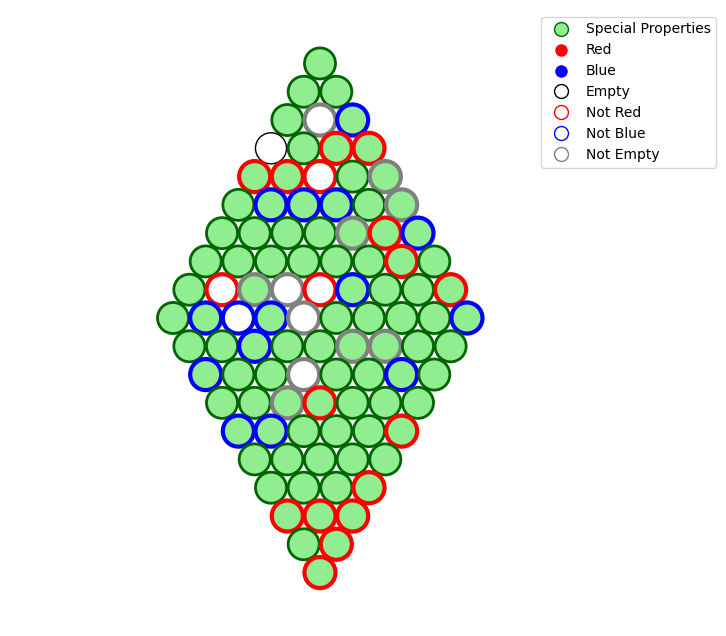

In [162]:
symbol_id = graphs_train.symbol_id  # Dict: symbol_name -> symbol_id

# Inverse mapping: symbol_id -> symbol_name
symbol_id_to_name = {v: k for k, v in symbol_id.items()}

# Mapping from symbol_id to assigned bit
symbol_id_to_bit = {}
for sid in symbol_id:
    bit = graphs_train.hypervectors[symbol_id[sid], 0]  # Assigned bit index
    symbol_id_to_bit[symbol_id[sid]] = bit

# Mapping from bit index to symbol name
bit_index_to_symbol_name = {}
for symbol_id, bit in symbol_id_to_bit.items():
    symbol_name = symbol_id_to_name[symbol_id]
    bit_index_to_symbol_name[bit] = symbol_name

# Clause printing and collection
clauses = []
weights = tm.get_state()[1].reshape(2, -1)
for i in range(tm.number_of_clauses):
    #print("Clause #%d W:(%d %d)" % (i, weights[0,i], weights[1,i]), end=' ')
    l = []
    for k in range(args.hypervector_size * 2):
        if tm.ta_action(0, i, k):
            if k < args.hypervector_size:
                bit_index = k
                sign = ''
            else:
                bit_index = k - args.hypervector_size
                sign = 'NOT '
            symbol_name = bit_index_to_symbol_name.get(bit_index, f'x{bit_index}')
            l.append(f"{sign}{symbol_name}")
    clause_str = " AND ".join(l)
    clauses.append(clause_str)
    if i == 20:
        print(f"\n\n{clause_str}\n\n")

# Visualize the first clause
if len(clauses) > 0:
    clause_str = clauses[4]
    clause_info = parse_clause(clause_str)
    visualize_clause_on_board(size=board_size, clause_info=clause_info)
else:
    print("No clauses to visualize.")
